# Lab 12 (Module 11)
## Bootstrapping
4/18/2018

### Announcements:
* Reminder: Problem Set due date is April 25th, usual submission rules apply. 
* Reminder: office hours for the remainder of the semester will be 1pm-3pm Tuesdays in room N455.


### Plan for Today's Lab
1. Introduction to Bootstrapping (10 min)
2. An Example in R (15 min)


## 2-Conceptual Explanation of Bootstrapping
* Statistical tool that we can use to quantify uncertainty associated with an estimator or statistical learning method
* Simple example: standard errors for linear regression coefficients
* In most regression case R calculates this for us. Boostrapping advantages: (1) doesn't rely on assumptions (2) can also be applied to circumstances where measure of variability would be difficult to obtain and not automatically outputted by R.

### Illustrative Example
Consider a situation where you would like to invest $0\leq\alpha\leq1$ fraction of your funds in a financial asset which yields the random quantity X, and the remaining amount 1-α in a different financial asset which yields the random quantity Y.  Since there is variability associated with the returns on the two assets, we want to pick $\alpha$ to minimize the total risk or variance of our investment.  So, we want to minimize $Var(\alpha X+(1-\alpha)Y)$.  It’s possible to show that the value that minimizes the variance is equivalent to 

$\frac{Var(Y)-Cov(X,Y)}{Var(X)+Var(Y)-2Cov(X,Y)}$

Assume we know the true underlying value of the variances for each of the random variables X and Y: 

$Var(Y)=\sigma_Y^2=1.25$

$Var(X)=\sigma_X^2=1$

$Cov(XY)=\sigma_{XY}=0.5$

* Optimal portion of our income to invest in X is exactly as 0.6
* in the real world, we don’t know the true underlying variances
* Use past observations of X and Y to estimate the variances, and ultimately to estimate the optimal alpha.  Suppose we are able to observe a random sample of 100 past observations for X and Y and calculate :

$\hat{\alpha}=\frac{\hat{\sigma}_Y^2-\hat{\sigma}_{XY}}{\hat{\sigma}_X^2+\hat{\sigma}_Y^2-2\hat{\sigma}_{XY})}$
(1)

So, for one sample of 100 observations you obtain a single value of $\alpha$.  Without knowing the true underlying value of alpha, how can you know how accurate this estimate is?  For your investment purposes, you might want to know the standard error of your estimate for alpha, or how much you expect $\hat\alpha$ to differ from $\alpha$.  One way to calculate this standard error would be to draw more samples of 100 observations for X and Y, estimating $\hat\alpha$ each time, and then take the standard deviations of these estimates.  In a simulated example, 1000 samples of 100 observations for X and Y are drawn, with the $\hat\alpha$ calculated each time.  The average of these $\hat\alpha$ is found to be 0.5996, which is remarkably close to the true value of alpha.  The standard deviation of the estimates of $\hat\alpha$ is:

$SE(\hat{\alpha})=\sqrt{\frac{1}{1000-1}\sum_{r=1}^{1000}(\hat{\alpha}_{r}-\bar{\alpha})^{2}}=0.83$
(2)

This means that if we just relied on one random sample of size 100 from the population to estimate alpha, we would expect our estimate to differ from the true alpha by 0.08 on average.  But how can we calculate the standard error of our estimate if we have only one dataset of 100 observations?  

We can modify this procedure to allow us to calculate the standard error of $\hat\alpha$ using ONLY our original dataset of 100 observations.  Rather than repeatedly obtaining independent data sets from the population, we instead obtain distinct data sets by repeatedly sampling observations from the original data set with replacement.  In this case, imagine that we take our 100 observations of X and Y and write each pair of X and Y on a slip of paper, so we have 100 total slips in a bucket.  Then we randomly draw a slip, write down the value of X and Y, and toss the slip back into bucket.  We repeat this until we have 100 total observations in a new randomly drawn sample.  If we compare this new randomly drawn sample to our original, we might have, for example, 3 copies of observation 27, and no copies of observation 50.  We’ll calculate alpha in this new sample, and repeat this procedure, drawing a new sample with replacement from our original sample, and calculating alpha again.  We repeat a total of 1000 times, take these values and their average and compute the standard error using the formula (2) above.
  
In a simulation of bootstrapping from a single sample, we calculate the SE as 0.087.  See the figure below from ISL illustrating these two processes:

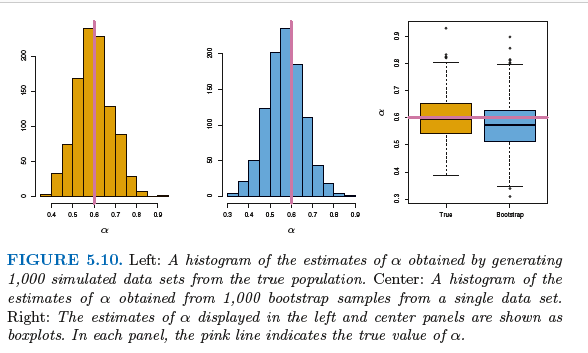
    
## 2-Examples in R
### Estimating the Accuracy of a Statistic of Interest
Performing a bootstrap analysis in R entails only two steps. First, we must create a function that computes the statistic of interest. Second, we use the boot() function, which is part of the boot library, to perform the bootstrap by repeatedly sampling observations from the data set with replacement. We will load the Portfolio data described in the example above, as well as the required boot(package).

In [1]:
# set working directory
setwd("/home/jovyan/mba217-2/Data")
# load package for bootstrapping
require(boot)
# Read the data and remove observations with missing data
Portfolio <- read.csv("Portfolio.csv", header = TRUE)
#list variable names
names(Portfolio)

Loading required package: boot


[1] "X.1" "X"   "Y"

To illustrate the use of the bootstrap on this data, we must first create a function, alpha.fn(), which takes as input the (X, Y ) data as well as a vector indicating which observations should be used to estimate α. The function then outputs the estimate for α based on the selected observations. 

This function returns, or outputs, an estimate for α based on applying formula (1) above to the observations indexed by the argument index. For instance, the following command tells R to estimate α using all 100 observations. 

In [2]:
alpha.fn=function (data ,index){
X=data$X[index]
Y=data$Y[index]
return ((var(Y)-cov(X,Y))/(var(X)+var(Y) -2*cov(X,Y)))
} 
alpha.fn(Portfolio ,1:100) 

[1] 0.5758321

The next command uses the sample() function to randomly select 100 observations from the range 1 to 100, with replacement. This is equivalent to constructing a new bootstrap data set and recomputing α ̂ based on the new data set. 

In [3]:
set.seed(1)
alpha.fn(Portfolio ,sample (100,100, replace=T))


[1] 0.5963833

We can implement a bootstrap analysis by performing this command many times, recording all of the corresponding estimates for α, and computing the resulting standard deviation. However, the boot() function automates this approach. Below we produce R = 1000 bootstrap estimates for α.

The final output shows that using the original data, $\hat{\alpha}=0.5758$, and that the bootstrap estimate for $SE(\hat{\alpha})$ is 0.0886.

In [19]:
?boot

In [18]:
boot(Portfolio ,alpha.fn,R=1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Portfolio, statistic = alpha.fn, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.5758321 0.002621328  0.09204561

### Estimating the Accuracy of a Linear Regression Model
The bootstrap approach can be used to assess the variability of the coefficient estimates and predictions from a statistical learning method. Here we use the bootstrap approach in order to assess the variability of the estimates for $β_0$ and $β_1$, the intercept and slope terms for the linear regression model that uses horsepower to predict mpg in the Auto data set. 

We will compare the estimates obtained using the bootstrap to those obtained using the formulas for $SE(\hat{\beta}_{0})$ and $SE(\hat{\beta}_{1})$: 

$SE(\hat{\beta}_{0})=\sigma^{2}\left[\frac{1}{n}+\frac{\bar{x}^{2}}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}\right]$

$SE(\hat{\beta}_{1})^{2}=\frac{\sigma^{2}}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}$

These formulas require the assumption that the errors for $\epsilon_i$ for each observation are uncorrelated with common variance $\sigma^2$.   We first create a simple function, boot.fn(), which takes in the Auto data set as well as a set of indices for the observations, and returns the intercept and slope estimates for the linear regression model.

In [27]:
Auto <- read.csv("Auto.csv", header = TRUE)
names(Auto)
boot.fn=function (data,index){
return(coef(lm(mpg~horsepower,data=data,subset=index)))
    }

boot.fn1=function (data){
return(coef(lm(mpg~horsepower,data=data)))
    }

[1] "X"            "mpg"          "cylinders"    "displacement" "horsepower"  
 [6] "weight"       "acceleration" "year"         "origin"       "name"

Next, we use the boot() function to compute the standard errors of 1,000 bootstrap estimates for the intercept and slope terms. 

In [28]:
boot(Auto ,boot.fn1 , 1000)

ERROR: Error in statistic(data, original, ...): unused argument (original)


In [21]:
boot(Auto ,boot.fn ,1000) 


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* 39.9358610  0.0009580714 0.860062977
t2* -0.1578447 -0.0001806334 0.007497367

Instead, we can also use the standard forumlas to compute the standard errors and regression coefficients.  We do this using the usual lm command and the summary function.

In [29]:
summary (lm(mpg~horsepower ,data=Auto))$coef 

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),39.9358610,0.717498656,55.65984,1.220362e-187
horsepower,-0.1578447,0.006445501,-24.48914,7.031989e-81


Interestingly, these are somewhat different from the estimates obtained using the bootstrap. Does this indicate a problem with the bootstrap? In fact, it suggests the opposite. As stated above, the standard error formulas rely on certain assumptions. Although the formula for the standard errors do not rely on the linear model being correct, the estimate for $\sigma^2$  does. It turns out that there is a non-linear relationship in the data, and so the residuals from a linear fit will be inflated, and so will $\sigma^2$ . Secondly, the standard formulas assume (somewhat unrealistically) that the $x_i$ are fixed, and all the variability comes from the variation in the errors i. The bootstrap approach does not rely on any of these assumptions, and so it is likely giving a more accurate estimate of the standard errors of $β_0$ and $β_1$ than is the summary() function. 

Below we compute the bootstrap standard error estimates and the standard linear regression estimates that result from fitting the quadratic model to the data. Since this model provides a better fit to the data in comparison to the linear model, there is now a better correspondence between the bootstrap estimates and the standard estimates of for $SE(\hat{β}_0)$, $SE(\hat{β}_1)$, and $SE(\hat{β}_2)$.


In [32]:
?I

In [30]:
#bootstrap SEs with quadratic model
boot.fn=function (data ,index) 
coefficients(lm(mpg~horsepower +I(horsepower ^2),data=data , subset=index))
set.seed(1) 
boot(Auto ,boot.fn ,1000)
#use lm with quadratic model to calculate SEs using formula 
summary (lm(mpg~horsepower +I(horsepower ^2),data=Auto))$coef 



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
        original        bias     std. error
t1* 56.900099702  6.098115e-03 2.0944855842
t2* -0.466189630 -1.777108e-04 0.0334123802
t3*  0.001230536  1.324315e-06 0.0001208339

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),56.900099702,1.8004268063,31.60367,1.740911e-109
horsepower,-0.466189630,0.0311246171,-14.97816,2.289429e-40
I(horsepower^2),0.001230536,0.0001220759,10.08009,2.196340e-21


The plot below demonstrates the non-linear relationship between horsepower and mpg.

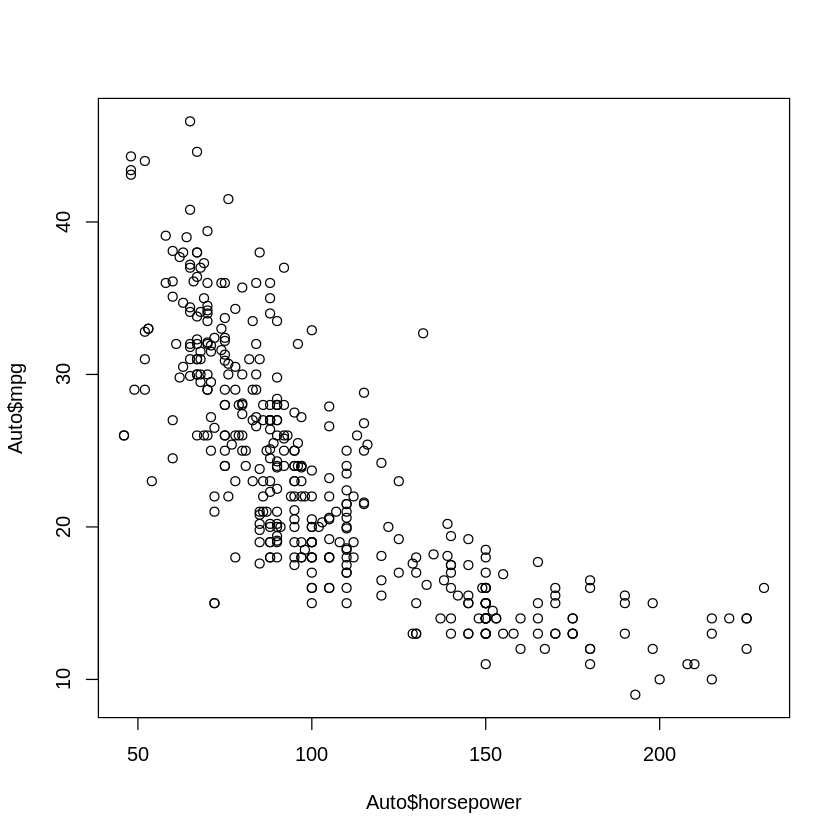

In [31]:
plot(Auto$horsepower, Auto$mpg)